© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/phd_students/seleznova/index.html) 2022

https://github.com/mselezniova/MSML22

Distributed under the [Creative Commons Attribution License](https://creativecommons.org/licenses/by/4.0/)

# Mini-batch SGD

In [27]:
%matplotlib inline
%config InlineBackend.figure_format='svg'

import matplotlib.pyplot as plt

import os

import numpy as np
import pandas as pd

Load the Iris dataset:

In [28]:
file_name = 'iris_data_set.csv'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
column_names = ['sepal length [cm]', 'sepal width [cm]',
                'petal length [cm]', 'petal width [cm]', 'iris type']

if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name, index_col=0)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url, names=column_names)
    df.to_csv(file_name)
    print('Done.')

Loading data from local file `iris_data_set.csv`...


Assign class labels -1 and 1 for binary classification:

In [29]:
df['class'] = df['iris type'].replace(
    ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'],
    [-1, 1, 1])

In [30]:
df

,sepal length [cm],sepal width [cm],petal length [cm],petal width [cm],iris type,class
0,5.1,3.5,1.4,0.2,Iris-setosa,-1
1,4.9,3.0,1.4,0.2,Iris-setosa,-1
2,4.7,3.2,1.3,0.2,Iris-setosa,-1
3,4.6,3.1,1.5,0.2,Iris-setosa,-1
4,5.0,3.6,1.4,0.2,Iris-setosa,-1
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica,1
146,6.3,2.5,5.0,1.9,Iris-virginica,1
147,6.5,3.0,5.2,2.0,Iris-virginica,1
148,6.2,3.4,5.4,2.3,Iris-virginica,1


Train-test split:

In [31]:
def  train_test_split(df, training_data_fraction, shuffle=True):
    
    if shuffle is True:
        df_ = df.sample(frac=1).reset_index(drop=True)
    else:
        df_= df
    
    train_df = df_.iloc[:round(training_data_fraction*len(df_)),:]
    test_df = df_.iloc[round(training_data_fraction*len(df_)):,:]
    
    return df_, train_df, test_df

In [32]:
training_data_fraction = .8

df, train_df, test_df =  train_test_split(df, training_data_fraction)

X = df.iloc[:,:-2].to_numpy()
Y = df.iloc[:,df.columns == 'class'].to_numpy().reshape(-1)

train_X = train_df.iloc[:,:-2].to_numpy()
train_Y = train_df.iloc[:,df.columns == 'class'].to_numpy().reshape(-1)

test_X = test_df.iloc[:,:-2].to_numpy()
test_Y = test_df.iloc[:,df.columns == 'class'].to_numpy().reshape(-1)

print('Training data split as follows:')
print(f'  Training data samples: {len(train_df)}')
print(f'      Test data samples: {len(test_df)}')

Training data split as follows:
  Training data samples: 120
      Test data samples: 30


Define a linear binary classification model with mini-batch SGD training as a class:

In [33]:
class LinearBinaryClassification:

    def __init__(self, w, b):
        self._w = np.array(w, dtype=float)
        self._b = np.array(b, dtype=float)
        self.history = [{'w': self._w.copy(),
                         'b': self._b.copy(),
                         'loss': None,
                         'accuracy': None}]
        
    def h(self, x):
        # Numpy's `where` function provides a fast substitution
        return np.where(x @ self._w + self._b >= 0.0, 1, -1)
    
    def accuracy(self, X, Y):
        return 1. - np.sum(self.h(X) != Y)/Y.size
    
    def loss(self, X, Y):
        ones_vec = np.ones(X.shape[0])
        return 0.5/X.shape[0]*np.dot(X@self._w + self._b*ones_vec - Y,
                          X@self._w + self._b*ones_vec - Y)
    
    def loss_grad(self, X,Y):
        ones_vec = np.ones(X.shape[0])
        return X.T@(X@self._w + self._b*ones_vec - Y)/X.shape[0], ones_vec.T@(X@self._w 
                                                                    + self._b*ones_vec - Y)/X.shape[0]
    
    def train(self, X, Y, lr = 1e-3, num_epochs = 10, batch_size=100):
        
        self.history[0]['loss'] = self.loss(X,Y)
        self.history[0]['accuracy'] = self.accuracy(X,Y)
        
        for e in range(num_epochs):
            perm_index = np.random.permutation(np.arange(X.shape[0]))
            n_batches = np.ceil(X.shape[0]/batch_size)
            batch_indices = np.array_split(perm_index,n_batches)
            
            for ind in batch_indices:
            
                grad_w, grad_b = self.loss_grad(X[ind],Y[ind])
                self._w -= lr*grad_w
                self._b -= lr*grad_b

                self.history.append({'w': self._w.copy(),
                                     'b': self._b.copy(),
                                     'loss': self.loss(X,Y),
                                     'accuracy': self.accuracy(X,Y)})
            
        return self._w, self._b



Plot learning curves for different batch sizes:

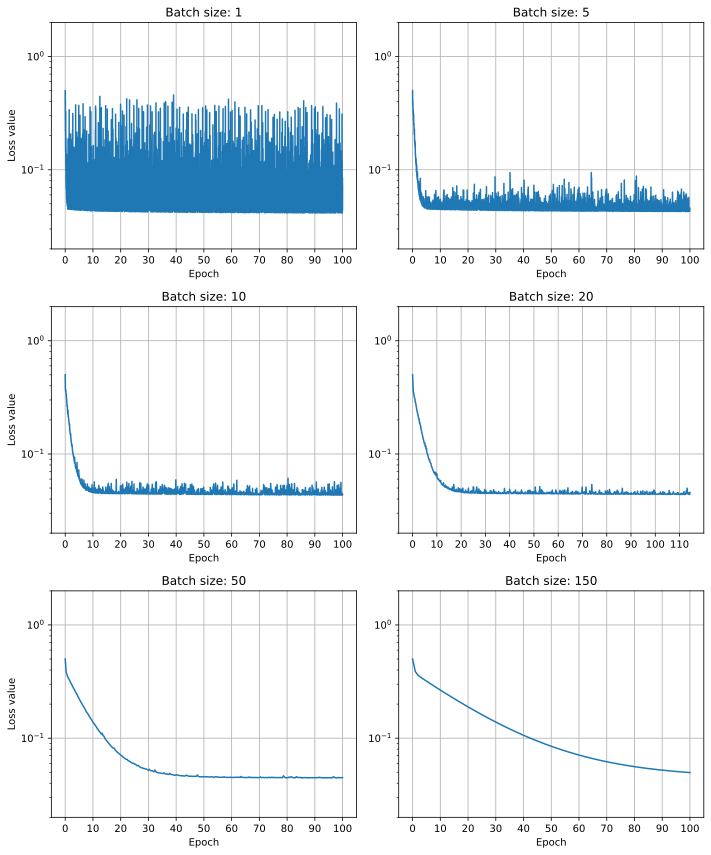

In [34]:
fig, ax = plt.subplots(int(len(batch_sizes)/2),2, figsize=(10,12))

w = np.array([0]*X.shape[1])
b = 0

batch_sizes = [1,5,10,20,50,X.shape[0]]

for batch_size, ax_ in zip(batch_sizes, ax.flatten()):
    model = LinearBinaryClassification(w, b)
    model.train(X,Y, lr=1e-2, num_epochs=100,batch_size=batch_size)
    
    loss_history = [h['loss'] for h in model.history]
    
    updates = np.array(range(len(model.history)))
    
    ax_.plot(updates, loss_history)
    
    ax_.grid()
    ax_.set_yscale('log')
    ax_.set_xlabel('Epoch')
    ax_.set_title(f'Batch size: {batch_size}')
    
    upd_per_epoch = int(X.shape[0]/batch_size)
    epochs_ind = np.array(range(0,len(model.history),10*upd_per_epoch))
    epochs_num = updates[epochs_ind]/upd_per_epoch
    
    ax_.set_xticks(epochs_ind,epochs_num.astype(int))
    ax_.set_ylim([0.02,2])
    
for ax_ in ax[:,0]:
    ax_.set_ylabel('Loss value')

fig.tight_layout()